# 과수화상병 데이터를 통한 이미지 분류 모델 구축하기

# Description

- Dataset : 주요 과수(사과, 배)의 화상병 및 유사 병종의 이미지 데이터
- Purpose : 과수화상병 진단 및 처방 목적의 학습 데이터 구축을 통해 이미지 분류 모델을 배포하기

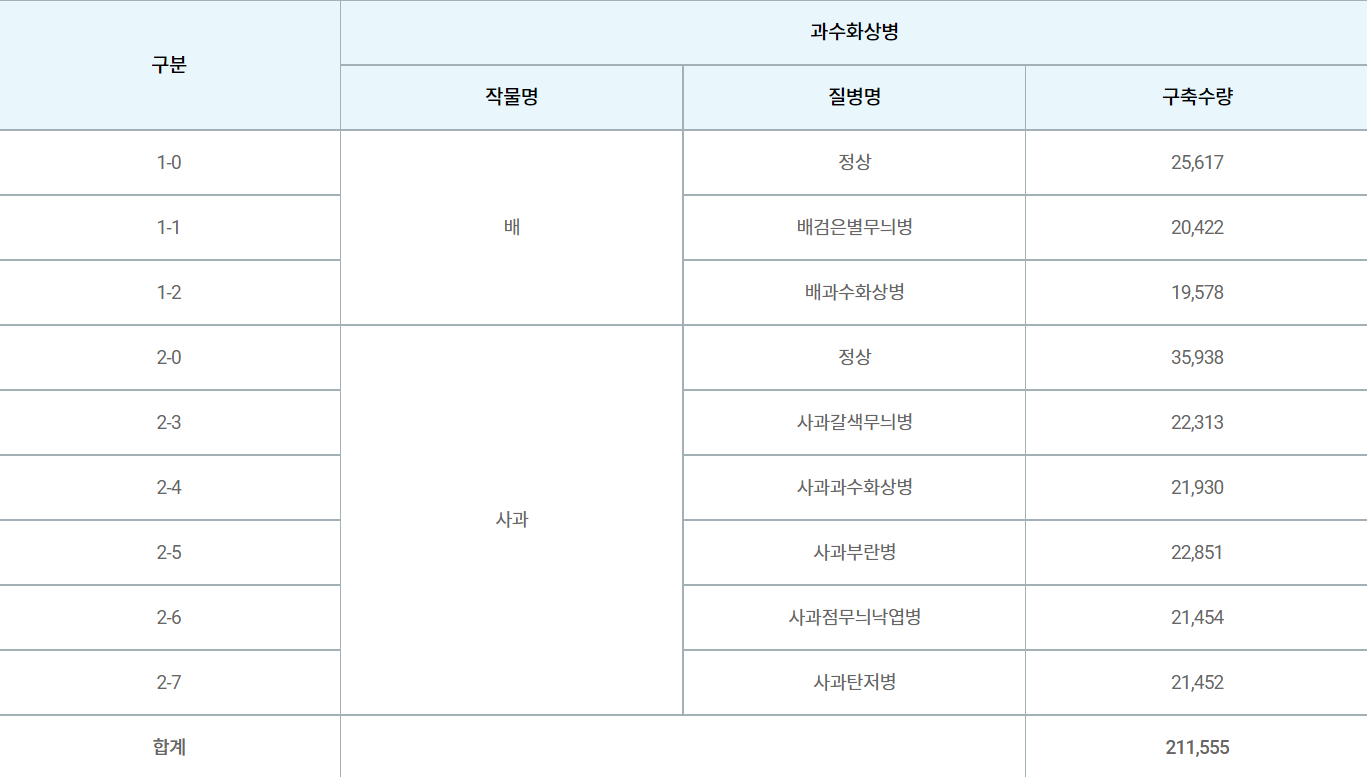

# Import libraries & load dataset

In [32]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

import random
import cv2
import os
import glob
# use gpu
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import math
import scipy as sp
import PIL
from PIL import Image, ImageOps
import copy
import itertools

# Tensorflow
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# split dataset
import splitfolders

# ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

# flask
from flask import Flask
from flask import render_template
from flask import request

# json 
import json
import xmltodict
from json2xml import json2xml
from pandas.io.json import json_normalize
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, SubElement, ElementTree

In [2]:
pear= './Train/배/'

In [3]:
# 부위 별
Train_x = []
Train_y = []
    
for FileName in os.listdir(pear + '00_배정상/'):
    temp = copy.deepcopy(PIL.Image.open(pear + '00_배정상/' + FileName))
    Train_x.append(temp)
    Train_y.append(0)
    
for FileName in os.listdir(pear + '01_배검은별무늬병/'):
    temp = copy.deepcopy(PIL.Image.open(pear + '01_배검은별무늬병/' + FileName))
    Train_x.append(temp)
    Train_y.append(1)

for FileName in os.listdir(pear + '02_배과수화상병/'):
    temp = copy.deepcopy(PIL.Image.open(pear + '02_배과수화상병/' + FileName))
    Train_x.append(temp)
    Train_y.append(2)     

In [4]:
Train_x = np.stack(Train_x, axis=0 )
Train_y = np.array(Train_y)
print(Train_x.shape) # RGB
print(Train_y.shape)

(22991, 224, 224, 3)
(22991,)


In [5]:
pear1 = './Test/배/'

In [6]:
Test_x = []
Test_y = []

for FileName in os.listdir(pear1 + '00_배정상/'):
    temp = copy.deepcopy(PIL.Image.open(pear1 + '00_배정상/' + FileName))
    Test_x.append(temp)
    Test_y.append(0)
    
for FileName in os.listdir(pear1 + '01_배검은별무늬병/'):
    temp = copy.deepcopy(PIL.Image.open(pear1 + '01_배검은별무늬병/' + FileName))
    Test_x.append(temp)
    Test_y.append(1)

for FileName in os.listdir(pear1 + '02_배과수화상병/'):
    temp = copy.deepcopy(PIL.Image.open(pear1 + '02_배과수화상병/' + FileName))
    Test_x.append(temp)
    Test_y.append(2)

In [7]:
Test_x = np.stack(Test_x, axis=0)
Test_y = np.array(Test_y)
print(Test_x.shape) 
print(Test_y.shape)

(2880, 224, 224, 3)
(2880,)


In [8]:
train_directory = pear
test_directory  = pear1
model_directory = './Models/'
tensorboard_directory = './Tensorboard/'

In [14]:
img_width, img_height = 224, 224
batch_size = 32

In [15]:
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [16]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    classes=["00_배정상","01_배검은별무늬병","02_배과수화상병"],
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical", # sigmoid
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    classes=["00_배정상", "01_배검은별무늬병","02_배과수화상병"],
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode="categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    classes=["00_배정상", "01_배검은별무늬병","02_배과수화상병"],
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical')


# sigmoid / binary / binary_crossentropy
# softmax / categorical / categorical_crossentropy

Found 20693 images belonging to 3 classes.
Found 2298 images belonging to 3 classes.
Found 2880 images belonging to 3 classes.


In [34]:
base_model = tf.keras.applications.ResNet50(include_top=False, pooling = 'avg' , input_shape = (img_width, img_height,3), weights = 'imagenet')
base_model.trainable = False 

inputs = Input(shape=(img_width,img_height,3))
x = tf.keras.layers.experimental.preprocessing.Resizing(img_width, img_height)(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = Flatten()(x)
outputs = Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                             

In [35]:
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='MODEL/Resnet50-{epoch:03d}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5',
            monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=2, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [37]:
# 모델 컴파일 진행 - 아까와 달리 categorical_crossentropy 사용 > label이 숫자형 데이터이므로
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

# early stopping 설정
# early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [39]:
with tf.device('/device:GPU:0'):
    model.fit(
            TRAIN_GENERATOR,
            steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
            epochs=10,
            callbacks=CALLBACK,
            shuffle=True, 
            validation_data=VALID_GENERATOR)

Epoch 1/10
647/646 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.8892
Epoch 1: val_accuracy improved from -inf to 0.88903, saving model to MODEL\Resnet50-001-0.4014-0.8890.hdf5
646/646 [==============================] - 171s 264ms/step - loss: 0.3843 - accuracy: 0.8892 - val_loss: 0.4014 - val_accuracy: 0.8890 - lr: 0.0010
Epoch 2/10
647/646 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8923
Epoch 2: val_accuracy improved from 0.88903 to 0.89034, saving model to MODEL\Resnet50-002-0.3794-0.8903.hdf5
646/646 [==============================] - 160s 247ms/step - loss: 0.3632 - accuracy: 0.8923 - val_loss: 0.3794 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 3/10
647/646 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8930
Epoch 3: val_accuracy did not improve from 0.89034
646/646 [==============================] - 161s 249ms/step - loss: 0.3531 - accuracy: 0.8930 - val_loss: 0.3749 - val_accuracy: 0.8899 - lr: 0.0010
